In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model

%matplotlib inline

np.random.seed(1) # set a seed so that the results are consistent

In [2]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    

def sigmoid(x):
    """
    Compute the sigmoid of x
    Arguments:
    x -- A scalar or numpy array of any size.
    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

In [3]:
X, Y = load_planar_dataset()
print(X.shape)
print(Y.shape)

(2, 400)
(1, 400)


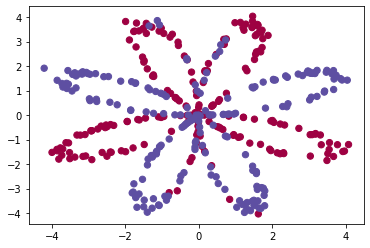

In [4]:
plt.scatter(X[0, :], X[1, :], c=Y.ravel(), s=40, cmap=plt.cm.Spectral);

In [5]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='liblinear', multi_class='ovr')
logreg.fit(X.T,Y.ravel().T)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)


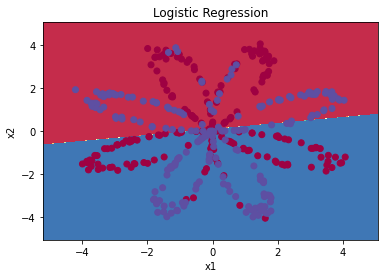

In [6]:
plot_decision_boundary(lambda x: logreg.predict(x), X, Y.ravel())
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = logreg.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) + '% ' + "(percentage of correctly labelled datapoints)")

In [7]:
# This function initializes the parameters of our network
# We will have a network with two layers, thus we need parameters W1 and b1 for
# the first layer and W2 and b2 for the second layer
# Remember that the weights can't be initialized to 0 but rather small random values
# n_x represents the number of input features
# n_h represents the number of hidden units (in the hidden layer)
# n_y represents the number of output units
def init_params(n_x, n_h, n_y):
    np.random.seed(2) 
    W1 = np.random.randn(n_h, n_x)* 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)* 0.01
    b2 = np.zeros((n_y, 1))
    
    params = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return params

# For ease of use we will store the parameters in a dictionary called params

In [8]:
# This function performs forward propagation
# it receives as parameters the matrix X containing the input features for the entire training set
# and the paramters of the network in the dictionary params
def forward_propagation(X, params):
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']
    Z1 = np.dot(W1, X) + b1
    # Z1 = np.tanh(W1, X) + b1
    
    # A1 = sigmoid(Z1)
    A1 = np.tanh(Z1)

    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    forwd = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, forwd

# We will store the Zi and Ai matrixes in a dictionary called forwd
# for ease of use we will also separately return A2 which corresponds with the output of the network

In [9]:
# Here we compute the cost function over the entire training set
# all we need is the predicted value by the network (Y_pred) 
# and the actual class of the training examples (Y)
def compute_cost(Y_pred, Y):
    m = Y.shape[1] # number of example
    logprobs = np.multiply(np.log(Y_pred),Y) + np.multiply(np.log(1 - Y_pred), (1 - Y))
    cost = - (1/m) * np.sum(logprobs) 
    cost = float(np.squeeze(cost))  # makes sure cost is a real number.
    
    return cost

In [10]:
# This function performs backward propagation
# it calculates dW2, db2, dW1 and db1
def backward_propagation(params, forwd, X, Y):
    m = X.shape[1]
    W1 = params['W1']
    W2 = params['W2']

    A1 = forwd['A1']
    A2 = forwd['A2']
    
    dZ2 = A2 - Y  #dz in slide 10, result of applying the chain rule (see also slide 18)
    dW2 = 1/m*np.dot(dZ2, A1.T)
    db2 = 1/m*np.sum(dZ2, axis=1, keepdims=True)
    # dZ1 = np.multiply(np.dot(W2.T, dZ2), A1 - np.power(A1, 2)) # derivative of the sigmoidal function is a(1-a) see slides 10 and 18
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
    
    dW1 = 1/m*np.dot(dZ1, X.T)
    db1 = 1/m*np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads
# This function returns the gradients in a dictionary

In [11]:
# This function uses the gradients and the learning rate to update the parameters
def update_params(params, grads, learn_rate = 1.2):
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']

    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']

    # tami: gradients (theta = theta - alpha*dw (derivative of w1))
    W1 = W1 - learn_rate*dW1
    b1 = b1 - learn_rate*db1
    W2 = W2 - learn_rate*dW2
    b2 = b2 - learn_rate*db2

    params = {"W1": W1,
                "b1": b1,
                "W2": W2,
                "b2": b2}
    
    return params
# It returns the updated parameters

In [12]:
# Here we create and train the actual Neural Network model
# We receives the dataset features X and classes Y
# we receive the number of hidden units as a hyperparameter (n_h)
# and we also get as a hyperparameter how many iterations to train

# tami: num_iterations is the iteration of the gradient iteration step times
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    np.random.seed(3)
    n_x = X.shape[0]
    n_y = Y.shape[0] 

    params = init_params(n_x, n_h, n_y)

    # This loop is to perform the forward and backward iterations
    for i in range(0, num_iterations):
        # Inside the loop all the computations (forward and backward computations) are vectorized
        # Tami: A2 is the second layer result
        A2, forwd = forward_propagation(X, params) 
        cost = compute_cost(A2, Y)
        grads = backward_propagation(params, forwd, X, Y)
        params = update_params(params, grads)

        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return params
# The method returns the parameters of the network, which is what is learned
# ... and all we need to predict!

In [13]:
# This method uses the learned parameters and a set of input values to perform a prediction
def predict(params, X):
    Y_pred, forwd = forward_propagation(X, params)
    predictions = (Y_pred > 0.5)  # in a binary classification problem we predict 1 if the output (y_pred) is larger than 0.5

    return predictions

Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.288083
Cost after iteration 2000: 0.254385
Cost after iteration 3000: 0.233864
Cost after iteration 4000: 0.226792
Cost after iteration 5000: 0.222644
Cost after iteration 6000: 0.219731
Cost after iteration 7000: 0.217504
Cost after iteration 8000: 0.219440
Cost after iteration 9000: 0.218553


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

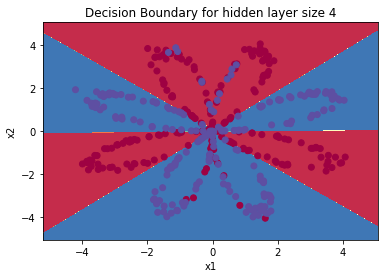

In [14]:
# Let's train a neural network with 4 hidden units for 10.000 iterations (epochs)
params = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# And now let's use the prediction to plot the decision boundary
plot_decision_boundary(lambda x: predict(params, x.T), X, Y.ravel())
plt.title("Decision Boundary for hidden layer size " + str(4))

In [15]:
# And this is the accuracy we got
predictions = predict(params, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 90%
